In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df_train = pd.read_csv(r"C:\Users\barta\Documents\cours\iaprojets\projet_aa\repo\Projet-AARES-20260202\part_1\data\raw\spotify_dataset_train.csv")
df_test = pd.read_csv(r"C:\Users\barta\Documents\cours\iaprojets\projet_aa\repo\Projet-AARES-20260202\part_1\data\raw\spotify_dataset_test.csv")

In [6]:
#preprocessing 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

class MusicFeatureEngineering(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.min_date_ = None

    def fit(self, X, y=None):
        dates = pd.to_datetime(X['release_date'], format='mixed')
        self.min_date_ = dates.min()
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy['release_date'] = pd.to_datetime(X_copy['release_date'], format='mixed')
        X_copy['days_since_1900'] = (X_copy['release_date'] - self.min_date_).dt.days
        X_copy['popularity'] = np.where(X_copy['popularity'] == 0, -1, X_copy['popularity'])       
        if 'explicit' in X_copy.columns:
            X_copy['explicit'] = X_copy['explicit'].astype(int)
        X_copy['explicit_popularity'] = X_copy['explicit'] * X_copy['popularity']
        X_copy['speechiness_explicit'] = X_copy['speechiness'] * X_copy['explicit']
        X_copy['energy_loudness'] = X_copy['energy'] * X_copy['loudness']
        X_copy['energy_acoustic_ratio'] = X_copy['energy'] / (X_copy['acousticness'] + 1e-6)
        X_copy['loudness_acoustic_ratio'] = X_copy['loudness'] / (X_copy['acousticness'] + 1e-6)
        X_copy['impact_score'] = (X_copy['speechiness'] * X_copy['popularity'] * X_copy['danceability'] )
        X_copy['impact_score_explicit']=X_copy['impact_score']* X_copy['explicit']
        

        cols_to_drop = ['release_date']
        X_copy = X_copy.drop(columns=[c for c in cols_to_drop if c in X_copy.columns])
        
        return X_copy

X = df_train.drop(columns=['genre'])
y = df_train['genre']

pipeline_X = Pipeline([
    ('feature_eng', MusicFeatureEngineering())])

label_encoder_y = LabelEncoder()

X_processed = pipeline_X.fit_transform(X)
y_encoded = label_encoder_y.fit_transform(y)


le pb de cette database est que je ne conserve pas le genre

## Resampling Values

C:\Users\barta\AppData\Local\Temp\ipykernel_19164\1161970130.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conteo_generos.index, y=conteo_generos.values, palette='viridis')


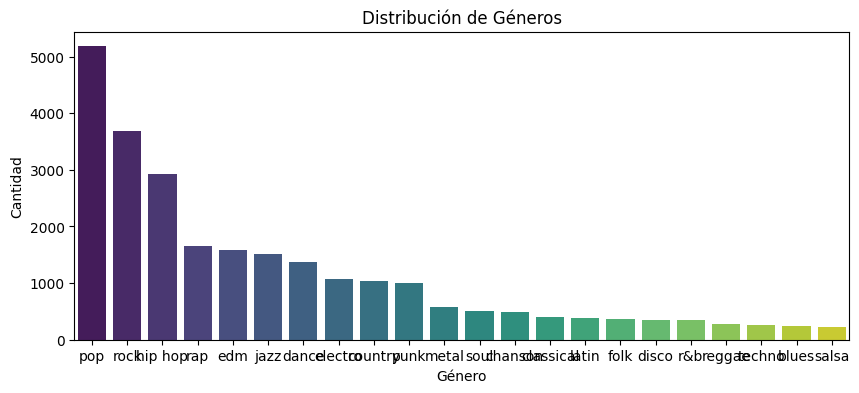

In [7]:


# Contar la cantidad de cada género
conteo_generos = df_train['genre'].value_counts()

# Crear el histograma
plt.figure(figsize=(10, 4))
sns.barplot(x=conteo_generos.index, y=conteo_generos.values, palette='viridis')
plt.title('Distribución de Géneros')
plt.xlabel('Género')
plt.ylabel('Cantidad')
plt.show()


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_encoded, test_size=0.2,stratify=y_encoded, random_state=42
)


### SMOTE

In [9]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

c:\Users\barta\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\barta\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\barta\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\barta\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, in _

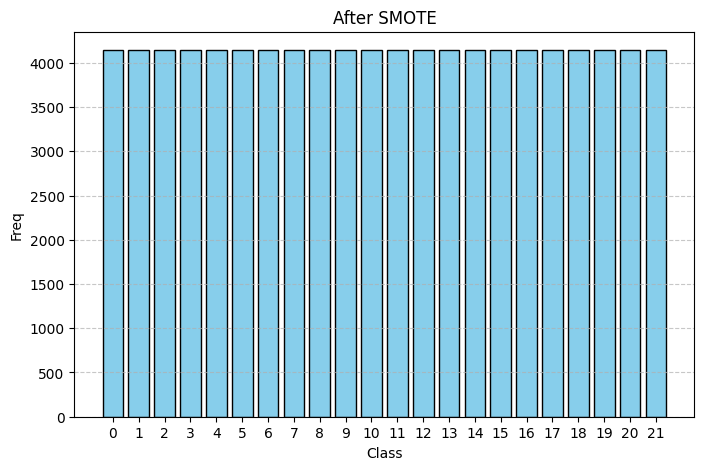

In [10]:
unique_classes, counts = np.unique(y_resampled, return_counts=True)

sorted_indices = np.argsort(unique_classes)
unique_classes_sorted = unique_classes[sorted_indices]
counts_sorted = counts[sorted_indices]

plt.figure(figsize=(8, 5))
plt.bar(unique_classes_sorted, counts_sorted, color='skyblue', edgecolor='black')
plt.title('After SMOTE')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.xticks(unique_classes_sorted)  # Asegura que las clases estén en orden en el eje x
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

redistrib 


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

# Exemple avec un Random Forest
model = RandomForestClassifier()
model.fit(X_resampled,y_resampled)
y_pred = model.predict(X_test)
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average='micro') #0.46440033281825743
#0.4263581094332222 smote



0.4263581094332222

In [12]:

from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_train, y_train)

KeyboardInterrupt: 

In [ ]:

# Pour l'affichage
for i in result.importances_mean.argsort()[::-1]:
    print(f"{X_train.columns[i]}: {result.importances_mean[i]:.4f}")

days_since_1900: 0.1108
valence: 0.0685
duration_ms: 0.0630
instrumentalness: 0.0599
danceability: 0.0552
energy: 0.0202
speechiness: 0.0153
acousticness: 0.0150
explicit: 0.0121
popularity: 0.0053
energy_loudness: 0.0049
speechiness_explicit: 0.0040
tempo: 0.0040
loudness_acoustic_ratio: 0.0038
energy_acoustic_ratio: 0.0034
loudness: 0.0023
mode: 0.0019
impact_score: 0.0018
liveness: 0.0008
impact_score_explicit: 0.0007
time_signature: 0.0004
key: 0.0004
explicit_popularity: 0.0001


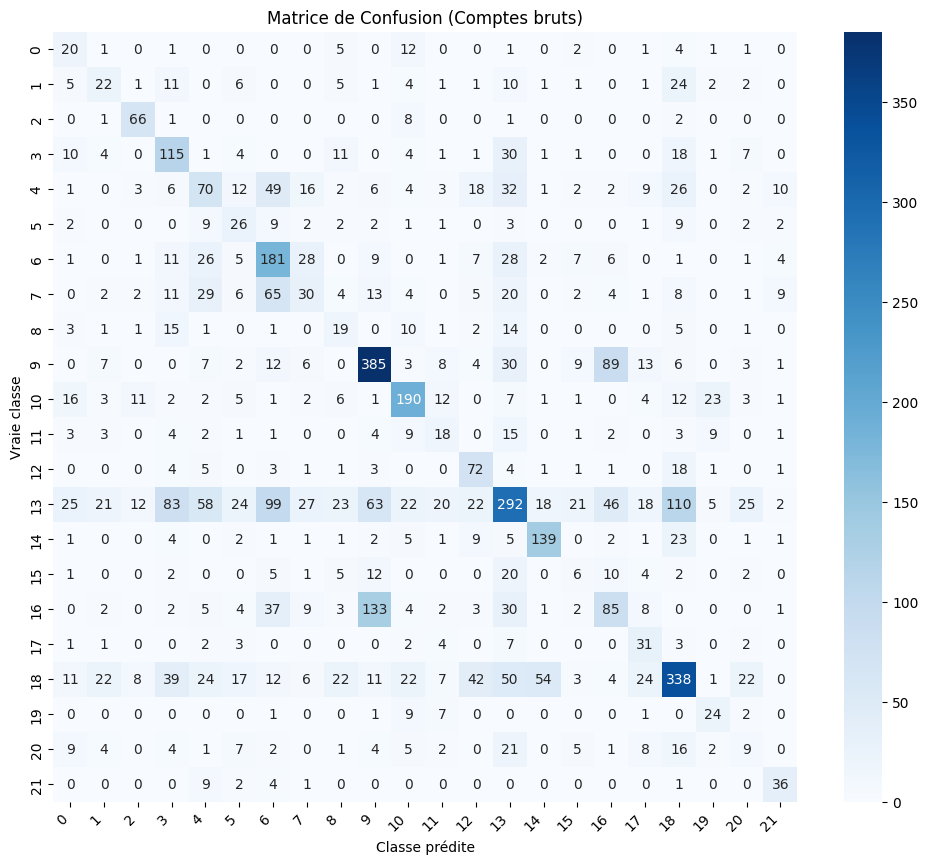

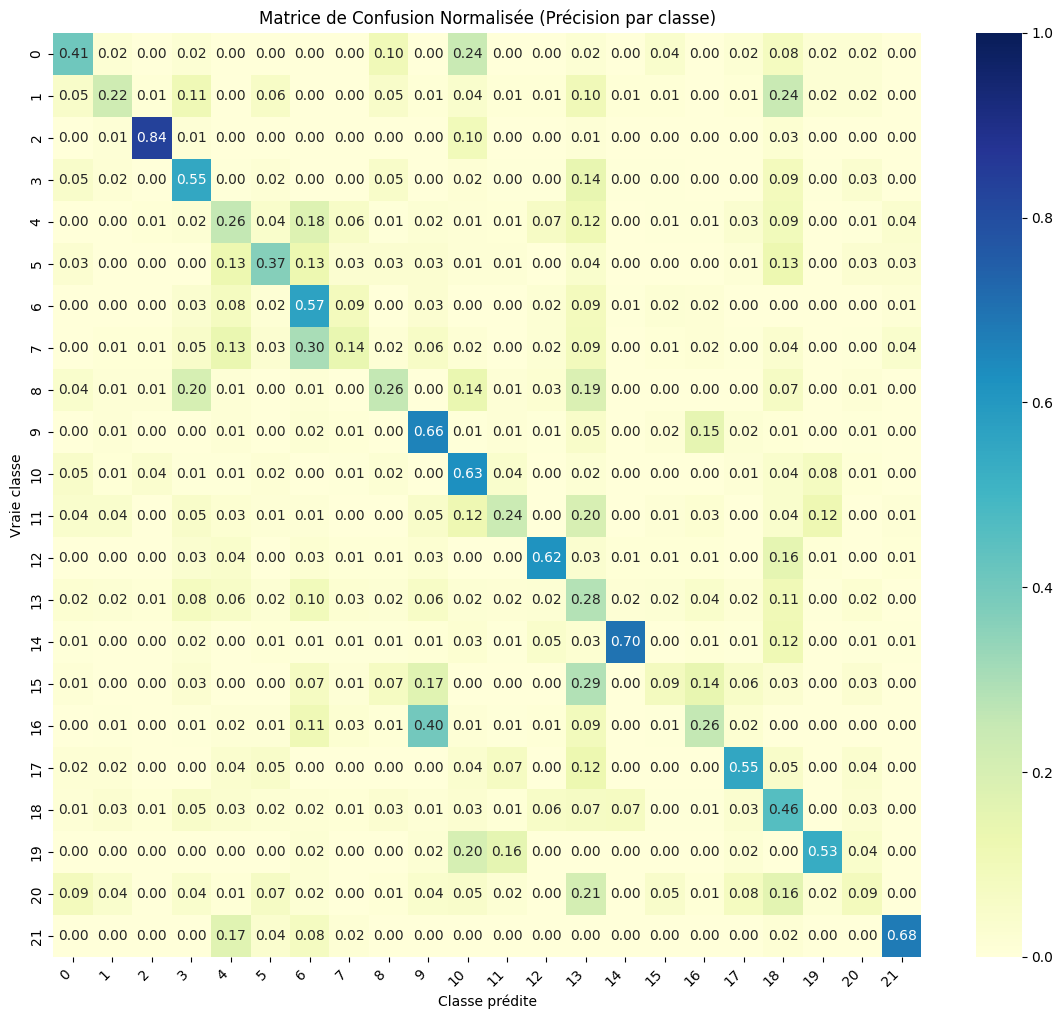

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcul de la matrice
cm = confusion_matrix(y_test, y_pred)

# Récupération des noms de classes (si vous avez un LabelEncoder 'le')
# Sinon, remplacez par une liste manuelle : ['Pop', 'Rock', ...]
# class_names = le.classes_ 
class_names = sorted(list(set(y_test))) # Fallback si pas de le

plt.figure(figsize=(12, 10)) # Grande taille nécessaire pour 23 classes !

sns.heatmap(cm, 
            annot=True,         # Affiche les chiffres dans les cases
            fmt='d',            # Format 'd' pour entiers (pas de notation scientifique)
            cmap='Blues',       # Dégradé de bleu (plus lisible)
            xticklabels=class_names,
            yticklabels=class_names)

plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.title('Matrice de Confusion (Comptes bruts)')
plt.xticks(rotation=45, ha='right') # Rotation pour lire les noms
plt.show()
import numpy as np

# On normalise par ligne ('true') -> La somme de chaque ligne fera 1 (100%)
cm_normalized = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(14, 12))

sns.heatmap(cm_normalized, 
            annot=True, 
            fmt='.2f',          # Affiche 2 décimales (ex: 0.85)
            cmap='YlGnBu',      # Jaune-Vert-Bleu (Jaune = 0%, Bleu foncé = 100%)
            xticklabels=class_names,
            yticklabels=class_names,
            vmin=0, vmax=1)     # Fixe l'échelle entre 0 et 1

plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.title('Matrice de Confusion Normalisée (Précision par classe)')
plt.xticks(rotation=45, ha='right')
plt.show()


In [16]:
from sklearn.ensemble import HistGradientBoostingClassifier
est = HistGradientBoostingClassifier().fit(X_resampled,y_resampled)
train_score = est.score(X_resampled, y_resampled)
print(f"Score sur l'entraînement : {train_score:.3f}")

# 3. Prédiction et évaluation sur le test
y_pred = est.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='micro')
print(f"F1-score sur le test : {test_f1:.3f}")


Score sur l'entraînement : 0.908
F1-score sur le test : 0.434


In [ ]:
# Pour l'affichage
for i in result.importances_mean.argsort()[::-1]:
    print(f"{X_test.columns[i]}: {result.importances_mean[i]:.4f}")

days_since_1900: 0.3545
instrumentalness: 0.2348
danceability: 0.2244
speechiness: 0.1962
valence: 0.1867
duration_ms: 0.1756
tempo: 0.1732
energy_acoustic_ratio: 0.1727
popularity: 0.1600
energy: 0.1456
acousticness: 0.1362
speechiness_explicit: 0.1094
loudness: 0.1064
energy_loudness: 0.1031
loudness_acoustic_ratio: 0.0953
impact_score: 0.0917
liveness: 0.0827
mode: 0.0577
explicit: 0.0573
key: 0.0560
impact_score_explicit: 0.0195
explicit_popularity: 0.0193
time_signature: 0.0067
